In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from tqdm.notebook import trange, tqdm
import joblib
import os
from sklearn.preprocessing import Normalizer , StandardScaler
import time

In [2]:
X = {'Inpatient_data_csv_file':r'D:\folder\assignments\CS1\Test_Inpatientdata-1542969243754.csv',
    'Outpatient_data_csv_file':r'D:\folder\assignments\CS1\Test_Outpatientdata-1542969243754.csv',
    'Beneficiary_data_csv_file':r'D:\folder\assignments\CS1\Test_Beneficiarydata-1542969243754.csv',
    'Test_provider_ID_csv_file':r'D:\folder\assignments\CS1\Test-1542969243754.csv'}

<h1>Function 1
<h3>Complete pipeline to take raw data and return predicted classes:

In [3]:
def Predict_Fraud(X):
    
    '''This function takes Inpatient,outpatient,Beneficiary and Provider Id in respective raw CSV file and flags predicted
    fradulent providers'''
    
    if not os.path.isfile(r'D:\folder\assignments\CS1\final_test_data.csv'):
        # starting time
        start = time.time()
        
        #loading the datasets from the CSVs
        inpatient = pd.read_csv(X['Inpatient_data_csv_file'])
        outpatient = pd.read_csv(X['Outpatient_data_csv_file'])
        beneficiary = pd.read_csv(X['Beneficiary_data_csv_file'])
        Test_provider_ID = pd.read_csv(X['Test_provider_ID_csv_file'])
        
        #Derving a new field as 'Admitted' 
        inpatient['Admitted'] = 1
        outpatient['Admitted'] = 0

        final_test_data = pd.merge(inpatient, outpatient,
                        left_on = [ idx for idx in outpatient.columns if idx in inpatient.columns],
                        right_on = [ idx for idx in outpatient.columns if idx in inpatient.columns],
                        how = 'outer').merge(beneficiary,left_on='BeneID',right_on='BeneID',how='inner')
        
        #Changing chronic condition indicators (from '2' to '0')
        final_test_data = final_test_data.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)
        
        #Changing chronic condition indicators (from 'Y' to '1')
        final_test_data = final_test_data.replace({'RenalDiseaseIndicator': 'Y'}, 1).astype({'RenalDiseaseIndicator': 'int64'})
        
        final_test_data = pd.merge(final_test_data, Test_provider_ID , how = 'outer', on = 'Provider' )
        
        #Derving a new field called 'WhetherDead'. If a person's 'Date of Death' is available then that dervied field is '0' otherwise '1'
        final_test_data.loc[final_test_data.DOD.isna(),'WhetherDead']=0
        final_test_data.loc[final_test_data.DOD.notna(),'WhetherDead']=1
        
        #Calculating No of days admitted, using two fields Admission Date and Discharge Date
        final_test_data['AdmissionDt'] = pd.to_datetime(final_test_data['AdmissionDt'] , format = '%Y-%m-%d')
        final_test_data['DischargeDt'] = pd.to_datetime(final_test_data['DischargeDt'],format = '%Y-%m-%d')
        final_test_data['AdmitForDays'] = ((final_test_data['DischargeDt'] - final_test_data['AdmissionDt']).dt.days)+1
        
        
        #Here Calcualting Insurance Claim amount reimbursed, Deductible amount, Inpatient Annual amount reimbursed, 
        #Outpatient Annual amount reimbursed avarege for each provider
        #Doing this beacuse from EDA we have found that amounts alone don't contribute much in classifying whether claim is fraud or not
        final_test_data["Provider_Avg_InscClaimAmtReimbursed"]=final_test_data.groupby('Provider')['InscClaimAmtReimbursed'].transform('mean')
        final_test_data["Provider_Avg_DeductibleAmtPaid"]=final_test_data.groupby('Provider')['DeductibleAmtPaid'].transform('mean')
        final_test_data["Provider_Avg_IPAnnualReimbursementAmt"]=final_test_data.groupby('Provider')['IPAnnualReimbursementAmt'].transform('mean')
        final_test_data["Provider_Avg_IPAnnualDeductibleAmt"]=final_test_data.groupby('Provider')['IPAnnualDeductibleAmt'].transform('mean')
        final_test_data["Provider_Avg_OPAnnualReimbursementAmt"]=final_test_data.groupby('Provider')['OPAnnualReimbursementAmt'].transform('mean')
        final_test_data["Provider_Avg_OPAnnualDeductibleAmt"]=final_test_data.groupby('Provider')['OPAnnualDeductibleAmt'].transform('mean')
        final_test_data["Provider_Avg_NoOfMonths_PartACov"]=final_test_data.groupby('Provider')['NoOfMonths_PartACov'].transform('mean')
        final_test_data["Provider_Avg_NoOfMonths_PartBCov"]=final_test_data.groupby('Provider')['NoOfMonths_PartBCov'].transform('mean')
        final_test_data["Provider_Avg_AdmitForDays"]=final_test_data.groupby('Provider')['AdmitForDays'].transform('mean')

        #Here Calcualting Insurance Claim amount reimbursed, Deductible amount, Inpatient Annual amount reimbursed, 
        #Outpatient Annual amount reimbursed avarege for each Beneficiary or Member
        final_test_data["BeneID_Avg_InscClaimAmtReimbursed"]=final_test_data.groupby('BeneID')['InscClaimAmtReimbursed'].transform('mean')
        final_test_data["BeneID_Avg_DeductibleAmtPaid"]=final_test_data.groupby('BeneID')['DeductibleAmtPaid'].transform('mean')
        final_test_data["BeneID_Avg_IPAnnualReimbursementAmt"]=final_test_data.groupby('BeneID')['IPAnnualReimbursementAmt'].transform('mean')
        final_test_data["BeneID_Avg_IPAnnualDeductibleAmt"]=final_test_data.groupby('BeneID')['IPAnnualDeductibleAmt'].transform('mean')
        final_test_data["BeneID_Avg_OPAnnualReimbursementAmt"]=final_test_data.groupby('BeneID')['OPAnnualReimbursementAmt'].transform('mean')
        final_test_data["BeneID_Avg_OPAnnualDeductibleAmt"]=final_test_data.groupby('BeneID')['OPAnnualDeductibleAmt'].transform('mean')
        final_test_data["BeneID_Avg_NoOfMonths_PartACov"]=final_test_data.groupby('BeneID')['NoOfMonths_PartACov'].transform('mean')
        final_test_data["BeneID_Avg_NoOfMonths_PartBCov"]=final_test_data.groupby('BeneID')['NoOfMonths_PartBCov'].transform('mean')
        final_test_data["BeneID_Avg_AdmitForDays"]=final_test_data.groupby('BeneID')['AdmitForDays'].transform('mean')
        
        #Here Calcualting Insurance Claim amount reimbursed, Deductible amount, Inpatient Annual amount reimbursed, 
        #Outpatient Annual amount reimbursed avarege for each Other Physician, Attending Physician, Operating Physician,
        #Also for 'DiagnosisGroupCode','ClmAdmitDiagnosisCode','ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3',
        #'ClmDiagnosisCode_1','ClmDiagnosisCode_2','ClmDiagnosisCode_3','ClmDiagnosisCode_4'
        columns = ['OtherPhysician','OperatingPhysician','AttendingPhysician','DiagnosisGroupCode','ClmAdmitDiagnosisCode',
           'ClmProcedureCode_1','ClmProcedureCode_2','ClmProcedureCode_3','ClmDiagnosisCode_1','ClmDiagnosisCode_2',
           'ClmDiagnosisCode_3','ClmDiagnosisCode_4']
        
        for column in columns:
            final_test_data["{}_Avg_InscClaimAmtReimbursed".format(column)]=final_test_data.groupby(column)['InscClaimAmtReimbursed'].transform('mean')
            final_test_data["{}_Avg_DeductibleAmtPaid".format(column)]=final_test_data.groupby(column)['DeductibleAmtPaid'].transform('mean')
            final_test_data["{}_Avg_IPAnnualReimbursementAmt".format(column)]=final_test_data.groupby(column)['IPAnnualReimbursementAmt'].transform('mean')
            final_test_data["{}_Avg_IPAnnualDeductibleAmt".format(column)]=final_test_data.groupby(column)['IPAnnualDeductibleAmt'].transform('mean')
            final_test_data["{}_Avg_OPAnnualReimbursementAmt".format(column)]=final_test_data.groupby(column)['OPAnnualReimbursementAmt'].transform('mean')
            final_test_data["{}_Avg_OPAnnualDeductibleAmt".format(column)]=final_test_data.groupby(column)['OPAnnualDeductibleAmt'].transform('mean')
            final_test_data["{}_Avg_NoOfMonths_PartACov".format(column)]=final_test_data.groupby(column)['NoOfMonths_PartACov'].transform('mean')
            final_test_data["{}_Avg_NoOfMonths_PartBCov".format(column)]=final_test_data.groupby(column)['NoOfMonths_PartBCov'].transform('mean')
            final_test_data["{}_Avg_AdmitForDays".format(column)]=final_test_data.groupby(column)['AdmitForDays'].transform('mean')
        
        #Calculating the count of claims for per provider and for a combination of provider and member. 
        #As fraud claims can be an organized crime the count taken by the provider and 
        #also for a combination of Provider and Member can be crucial.
        final_test_data["ClmCount_Provider"]=final_test_data.groupby(['Provider'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_BeneID"]=final_test_data.groupby(['Provider','BeneID'])['ClaimID'].transform('count')
        
        #Calculating the count of claims for a combination of provider and AttendingPhysician. 
        #As fraud claims can be an organized crime the count taken for a combination of 
        #Provider and AttendingPhysician or OtherPhysician or OperatingPhysician can be crucial.
        final_test_data["ClmCount_Provider_AttendingPhysician"]=final_test_data.groupby(['Provider','AttendingPhysician'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_OtherPhysician"]=final_test_data.groupby(['Provider','OtherPhysician'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_OperatingPhysician"]=final_test_data.groupby(['Provider','OperatingPhysician'])['ClaimID'].transform('count')
        
        #Calculating the count of claims for a combination of provider and all ClmProcedureCodes.
        final_test_data["ClmCount_Provider_ClmProcedureCode_1"]=final_test_data.groupby(['Provider','ClmProcedureCode_1'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmProcedureCode_2"]=final_test_data.groupby(['Provider','ClmProcedureCode_2'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmProcedureCode_3"]=final_test_data.groupby(['Provider','ClmProcedureCode_3'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmProcedureCode_4"]=final_test_data.groupby(['Provider','ClmProcedureCode_4'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmProcedureCode_5"]=final_test_data.groupby(['Provider','ClmProcedureCode_5'])['ClaimID'].transform('count')
        
        #Calculating the count of claims for a combination of provider and all ClmDiagnosisCodes.
        final_test_data["ClmCount_Provider_ClmAdmitDiagnosisCode"]=final_test_data.groupby(['Provider','ClmAdmitDiagnosisCode'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmDiagnosisCode_1"]=final_test_data.groupby(['Provider','ClmDiagnosisCode_1'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmDiagnosisCode_2"]=final_test_data.groupby(['Provider','ClmDiagnosisCode_2'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmDiagnosisCode_3"]=final_test_data.groupby(['Provider','ClmDiagnosisCode_3'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmDiagnosisCode_4"]=final_test_data.groupby(['Provider','ClmDiagnosisCode_4'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmDiagnosisCode_5"]=final_test_data.groupby(['Provider','ClmDiagnosisCode_5'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmDiagnosisCode_6"]=final_test_data.groupby(['Provider','ClmDiagnosisCode_6'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmDiagnosisCode_7"]=final_test_data.groupby(['Provider','ClmDiagnosisCode_7'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmDiagnosisCode_8"]=final_test_data.groupby(['Provider','ClmDiagnosisCode_8'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_ClmDiagnosisCode_9"]=final_test_data.groupby(['Provider','ClmDiagnosisCode_9'])['ClaimID'].transform('count')
        final_test_data["ClmCount_Provider_DiagnosisGroupCode"]=final_test_data.groupby(['Provider','DiagnosisGroupCode'])['ClaimID'].transform('count')
        
        Provider_ID = final_test_data['Provider'].values
        
        # end time
        end = time.time()

        # total time taken
        print(f"Runtime of the processing is: {end - start}")
        
        # starting time
        start = time.time()
        
        #this is the function to get the response encoded feature of the test dataset
        def get_response_feature_test(alpha, feature, train_df, feat_dict):
            value_count = train_df[feature].value_counts()
            res_fea = []
            for index, row in train_df.iterrows():
                if row[feature] in feat_dict.keys():
                    res_fea.append(feat_dict[row[feature]])
                else:
                    res_fea.append([1/2, 1/2])
            return res_fea

        def ResponseEncoder_test(categorical_cols, x_df, feat_dict):
            count = 0
            for i in categorical_cols:
                temp_response_coded_feature = np.array(get_response_feature_test(alpha=0, feature=i, train_df=x_df, feat_dict=feat_dict))
                if count == 0:
                    temp_response_coded_feature_com = temp_response_coded_feature
                    count += 1
                else:
                    temp_response_coded_feature_com = np.concatenate((temp_response_coded_feature_com,temp_response_coded_feature), axis=1)
            return temp_response_coded_feature_com
        
        diag_feat_dict = joblib.load('D:/folder/assignments/CS1/diag_feature_dict.npz')
        proc_feat_dict = joblib.load('D:/folder/assignments/CS1/proc_feature_dict.npz')
        
        Procedure_Codes = ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6']
        Diagnosis_Codes = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
                   'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8',
                   'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10', 'DiagnosisGroupCode', 'ClmAdmitDiagnosisCode']
        
        X_diag_test = ResponseEncoder_test(Diagnosis_Codes, final_test_data, diag_feat_dict)
        X_proc_test = ResponseEncoder_test(Procedure_Codes, final_test_data, proc_feat_dict)
        
        #Changing the encoded features in dataframes so that they can be concatenated
        new_features_diag = []
        for _ in Diagnosis_Codes:
            new_features_diag.append("{}_class_0".format(_))
            new_features_diag.append("{}_class_1".format(_))
            
        X_diag_test =  pd.DataFrame(X_diag_test, columns = new_features_diag)
        
        new_features_proc = []
        for _ in Procedure_Codes:
            new_features_proc.append("{}_class_0".format(_))
            new_features_proc.append("{}_class_1".format(_))
            
        X_proc_test =  pd.DataFrame(X_proc_test, columns = new_features_proc)
        
        # end time
        end = time.time()

        # total time taken
        print(f"Time taken in Response Encoding is : {end - start}")
    
        #Dropping these below columns from the dataset and we have extracted and engineered fields from the dataset in the earlier steps
        remove_these_columns=['BeneID', 'ClaimID', 'Provider', 'ClaimStartDt','ClaimEndDt','AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmDiagnosisCode_1',
       'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4',
       'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7',
       'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
       'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3',
       'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6',
       'ClmAdmitDiagnosisCode', 'AdmissionDt',
       'DischargeDt', 'DiagnosisGroupCode','DOB', 'DOD',
        'State', 'County']
        
        #Concatenating the features
        X_final_test = pd.concat([final_test_data,X_diag_test], axis=1)
        X_final_test = pd.concat([X_final_test,X_proc_test], axis=1)
        
        #Dropping the unnecessary features from the dataset
        X_final_test=X_final_test.drop(columns=remove_these_columns)
        
        cols1 = X_final_test.select_dtypes([np.number]).columns
        cols2 = X_final_test.select_dtypes(exclude = [np.number]).columns
        X_final_test[cols1] = X_final_test[cols1].fillna(value=0)
        
        #Storing the dataset
        X_final_test.to_csv(r'D:\folder\assignments\CS1\final_test_data.csv')
        
    else: 
        X_final_test = pd.read_csv(r'D:\folder\assignments\CS1\final_test_data.csv')
        X_final_test = X_final_test.drop(columns=['Unnamed: 0'])
        
    #starting the standardization process
    sc=StandardScaler()
    sc.fit(X_final_test)
    X_final_test = sc.transform(X_final_test)
        
    print('Final Test dataset shape after all preprocessing : ',X_final_test.shape)
        
    # starting time
    start = time.time()
    
    # model is being loaded, model has been trained on training data previously
    model = joblib.load(r'D:\folder\assignments\CS1\sclf.npz')

    def predict_with_best_t(proba, threshold):
        predictions = []
        for i in proba:
            if i>=threshold:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions
        
    y_pred_prob = model.predict_proba(X_final_test)[:,1]
    pred_output = predict_with_best_t(y_pred_prob, threshold = 0.01)
        
    # end time
    end = time.time()

    # total time taken
    print(f"Time taken in prediction by the model : {end - start}")
        
    prediction_df = pd.DataFrame()
    prediction_df['Provider_ID'] = Provider_ID
    prediction_df['prediction'] = pred_output
    
    return prediction_df

In [4]:
prediction_df= Predict_Fraud(X)

Runtime of the processing is: 13.330528736114502
Time taken in Response Encoding is : 544.5696125030518
Final Test dataset shape after all preprocessing :  (135392, 208)
Time taken in prediction by the model : 2.864871025085449


In [9]:
print('Predicting Potential Fraud:')
prediction_df

Predicting Potential Fraud:


,Provider_ID,prediction
0,PRV57070,1
1,PRV57070,1
2,PRV57070,1
3,PRV57070,1
4,PRV57070,1
...,...,...
135387,PRV54617,0
135388,PRV53736,0
135389,PRV53736,0
135390,PRV53089,0


<h1>Function 2:
<h3>Complete pipeline to take X,y as input and make evaluations of the model:

In [16]:
X_final_val = joblib.load('D:/folder/assignments/CS1/X_final_val.npz')
y_val = joblib.load('D:/folder/assignments/CS1/y_val.npz')

def Result_evalutaion(X,y):
    
    '''This function takes features and and corrosponding Target value as input and performs model evaluation'''

    # starting time
    start = time.time()
        
    model = joblib.load(r'D:\folder\assignments\CS1\sclf.npz')

    def predict_with_best_t(proba, threshold):
        predictions = []
        for i in proba:
            if i>=threshold:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions
        
    y_pred_prob = model.predict_proba(X)[:,1]
    pred_output = predict_with_best_t(y_pred_prob, threshold = 0.01)
        
    # end time
    end = time.time()

    # total time taken
    print(f"Time taken in prediction by the model : {end - start}")
    
    def plot_confusion_matrix(y, pred_output):
        c_mat = confusion_matrix(y, pred_output)
        accuracy=(c_mat[0,0]+c_mat[1,1])/sum(sum(c_mat))
        print ('Accuracy for the Train: ', accuracy)
        recall=c_mat[1,1]/(c_mat[1,0]+c_mat[1,1])
        print ('Recall of the model: ', recall)

        print("Train confusion matrix:")
        print("="*100)
        cmap=sns.light_palette("green")
        sns.heatmap(c_mat, annot=True, cmap=cmap)
        plt.show()
        
    plot_confusion_matrix(y, pred_output)    
    prediction_df = pd.DataFrame()
    
    prediction_df['Prediction'] = pred_output
    prediction_df['True_class'] = y.values
    
    return prediction_df

Time taken in prediction by the model : 1.606024980545044
Accuracy for the Train:  0.78252
Recall of the model:  0.8599948480164864
Train confusion matrix:


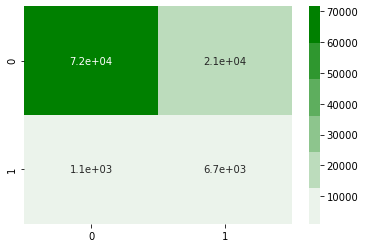

In [17]:
evalutaion = Result_evalutaion(X_final_val,y_val)

In [18]:
#Note: Recall has been preferred to AUC as the model should be predicting more the True Positives 
#and should reduce the prediction of False Negatives

In [8]:
evalutaion

,Prediction,True_class
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
99995,0,0
99996,0,0
99997,0,0
99998,0,0
